Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


Epoch 1/10
105/105 [==============================] - 1736s 17s/step - loss: 0.1887 - accuracy: 0.9250 - val_loss: 0.1998 - val_accuracy: 0.9024
Epoch 2/10
105/105 [==============================] - 1717s 16s/step - loss: 0.0906 - accuracy: 0.9682 - val_loss: 0.1117 - val_accuracy: 0.9548
Epoch 3/10
105/105 [==============================] - 1701s 16s/step - loss: 0.0576 - accuracy: 0.9851 - val_loss: 0.0828 - val_accuracy: 0.9774
Epoch 4/10
105/105 [==============================] - 1637s 16s/step - loss: 0.0453 - accuracy: 0.9869 - val_loss: 0.0967 - val_accuracy: 0.9655
Epoch 5/10
105/105 [==============================] - 1685s 16s/step - loss: 0.0404 - accuracy: 0.9869 - val_loss: 0.0719 - val_accuracy: 0.9798
Epoch 6/10
105/105 [==============================] - 1628s 16s/step - loss: 0.0344 - accuracy: 0.9896 - val_loss: 0.0648 - val_accuracy: 0.9798
Epoch 7/10
105/105 [==============================] - 1685s 16s/step - loss: 0.0357 - accuracy: 0.9866 - val_loss: 0.0557 - val_ac

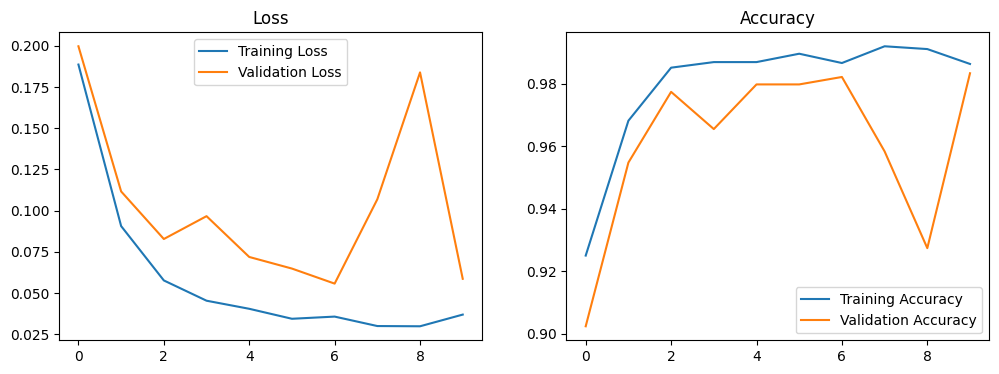

27/27 [==============================] - 321s 12s/step
Matriz de Confusión:
[[596 104]
 [118  22]]
Informe de Clasificación:
              precision    recall  f1-score   support

      Normal       0.83      0.85      0.84       700
Tuberculosis       0.17      0.16      0.17       140

    accuracy                           0.74       840
   macro avg       0.50      0.50      0.50       840
weighted avg       0.72      0.74      0.73       840



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Directorio de datos
data_dir = '/content/drive/MyDrive/DenseNet'
image_size = (224, 224)
batch_size = 32

# Configurar generadores de datos
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Cargar el modelo VGG16 preentrenado
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Congelar las capas de VGG16
for layer in base_model.layers:
    layer.trainable = False

# Crear la parte de U-Net
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool2)
    up1 = Conv2D(64, 2, activation='relu', padding='same')(up1)
    up1 = UpSampling2D(size=(2, 2))(up1)
    merge1 = concatenate([conv1, up1], axis=3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(merge1)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv3)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Crear el modelo U-Net
unet_input_shape = (224, 224, 3)
unet = unet_model(unet_input_shape)

# Redefinir VGG16 con una capa GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Crear el modelo final
final_model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
final_model.compile(optimizer=Adam(lr=1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Entrenar el modelo
epochs = 10

history = final_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Visualizar la gráfica de ganancia y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# Evaluar el modelo y generar el informe de clasificación
y_true = validation_generator.classes
y_pred = final_model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusión:")
print(cm)

classification_rep = classification_report(y_true, y_pred, target_names=['Normal', 'Tuberculosis'])
print("Informe de Clasificación:")
print(classification_rep)
